### Preamble
Import relevant Python libraries, including Phosphoros plot utilities and NNPZ.

In [1]:
%matplotlib inline
import Euclid
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from astropy.table import Table, join, vstack
from astropy import units as u
from astropy.units import photometric
from astropy.coordinates import SkyCoord
from glob import glob
import healpy
from tqdm.notebook import tqdm

# Silence numpy warnings, since there are NaN around
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
plt.rcParams['figure.figsize'] = (20, 10)

In [3]:
%elogin
%erun Phosphoros
%erun PHZ_NNPZ

In [4]:
from nnpz.reference_sample.ReferenceSample import ReferenceSample
from PhzCLI.PlotSpecZComparison import SpeczPhotozPlot, displayHistogram, compute_stats, boxPlot

# Input catalogs and NNPZ configuration

In [5]:
nnpz_config_path = '/home/aalvarez/Work/Data/WillHartley/nnpz.conf'
nnpz_config = dict()
exec(open(nnpz_config_path, 'rt').read(), nnpz_config)

## PHZ and MER

In [6]:
# All stats will be done with this point estimate
phz_column = 'REDSHIFT_MODE'

In [7]:
phz_catalog_path = '/home/aalvarez/Work/Data/WillHartley/lognorm005.fits'

In [8]:
phz_catalog = Table.read(phz_catalog_path, hdu=1)

## Filter out NaN
If there are any NaN on the Z point estimate, it will propagate and make all stats NaN, so we need to filter them out.

In [9]:
phz_isnan = np.isnan(phz_catalog[phz_column])
if phz_isnan.any():
    print(f'Found {phz_isnan.sum()} records with a NaN PHZ! Removing them.')
    phz_catalog = phz_catalog[phz_isnan == False]

## Compute AB magnitudes
A cut is applied on VIS magnitude, but we compute for all bands here.

In [10]:
for flux in [flux for flux in phz_catalog.colnames if flux.startswith('Flux_')]:
    band = '_'.join(flux.split('_')[1:])
    print(f'Computing MAG_AB_{band}')
    phz_catalog[f'MAG_AB_{band}'] = (phz_catalog[flux] * u.uJy).to(u.mag(photometric.AB))

Computing MAG_AB_vis
Computing MAG_AB_u
Computing MAG_AB_g
Computing MAG_AB_r
Computing MAG_AB_i
Computing MAG_AB_z
Computing MAG_AB_Y
Computing MAG_AB_J
Computing MAG_AB_H


## Apply cuts
VIS SNR must be $\ge$ 10, and VIS magnitude cut between 17 and 24.

In [11]:
snr_vis_cut = (phz_catalog['Flux_vis'] / phz_catalog['Fluxerr_vis'] >= 10)
mag_vis_cut = np.logical_and(phz_catalog['MAG_AB_vis'] >= 17, phz_catalog['MAG_AB_vis'] <= 24.5)

In [12]:
phz_cut_catalog = phz_catalog#[np.logical_and(snr_vis_cut, mag_vis_cut)]
print(len(phz_cut_catalog))

1000


# Validate with true Z

In [13]:
data, mean, median, sigma, mad, outliersPercent,sigmaNoOutliers, meanNoOutliers = compute_stats(phz_cut_catalog['z'], phz_cut_catalog[phz_column])

--> Mean                :  0.0058340016
--> Median              :  0.0053290045
--> Sigma               :  0.050494876
--> Mad                 :  0.010802172
--> Outliers            :  2.1 %
--> Sigma (no outliers) :  0.027772885


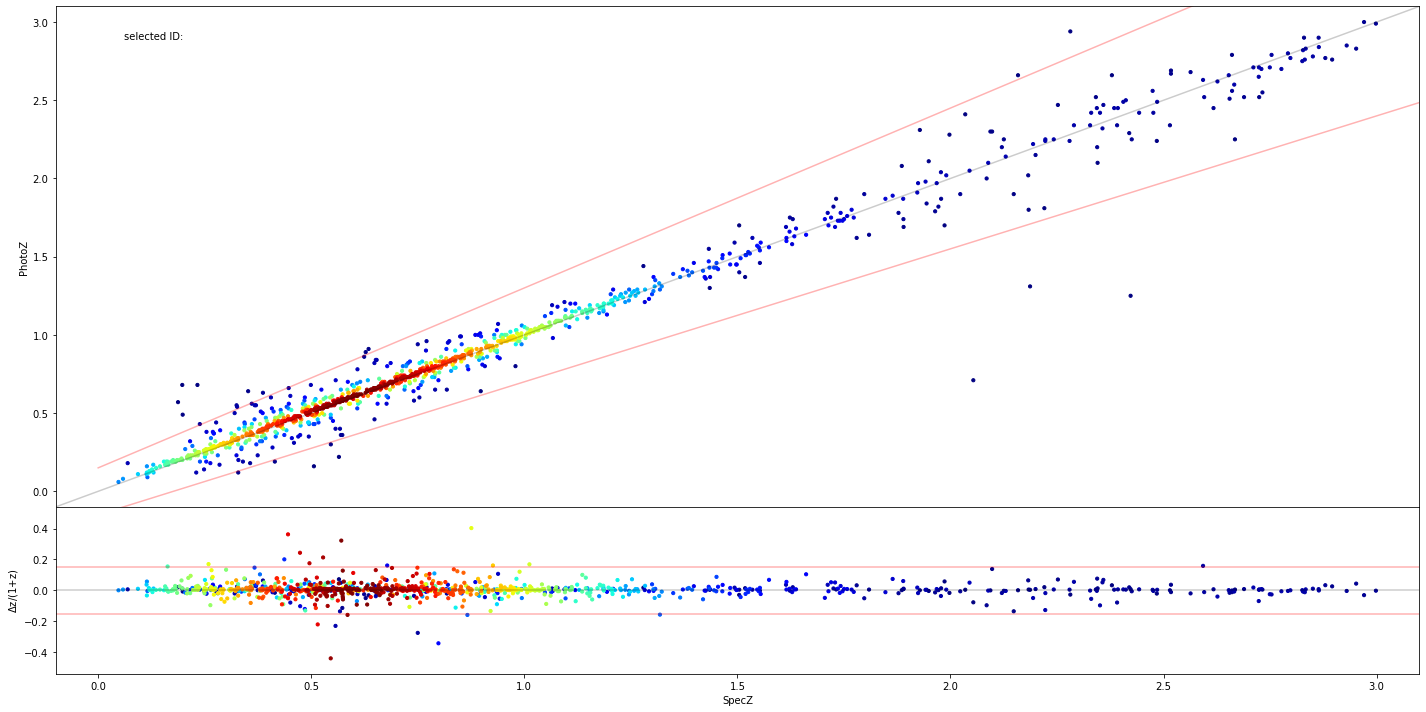

In [14]:
SpeczPhotozPlot(phz_cut_catalog['ID'], phz_cut_catalog['z'], phz_cut_catalog[phz_column], data)

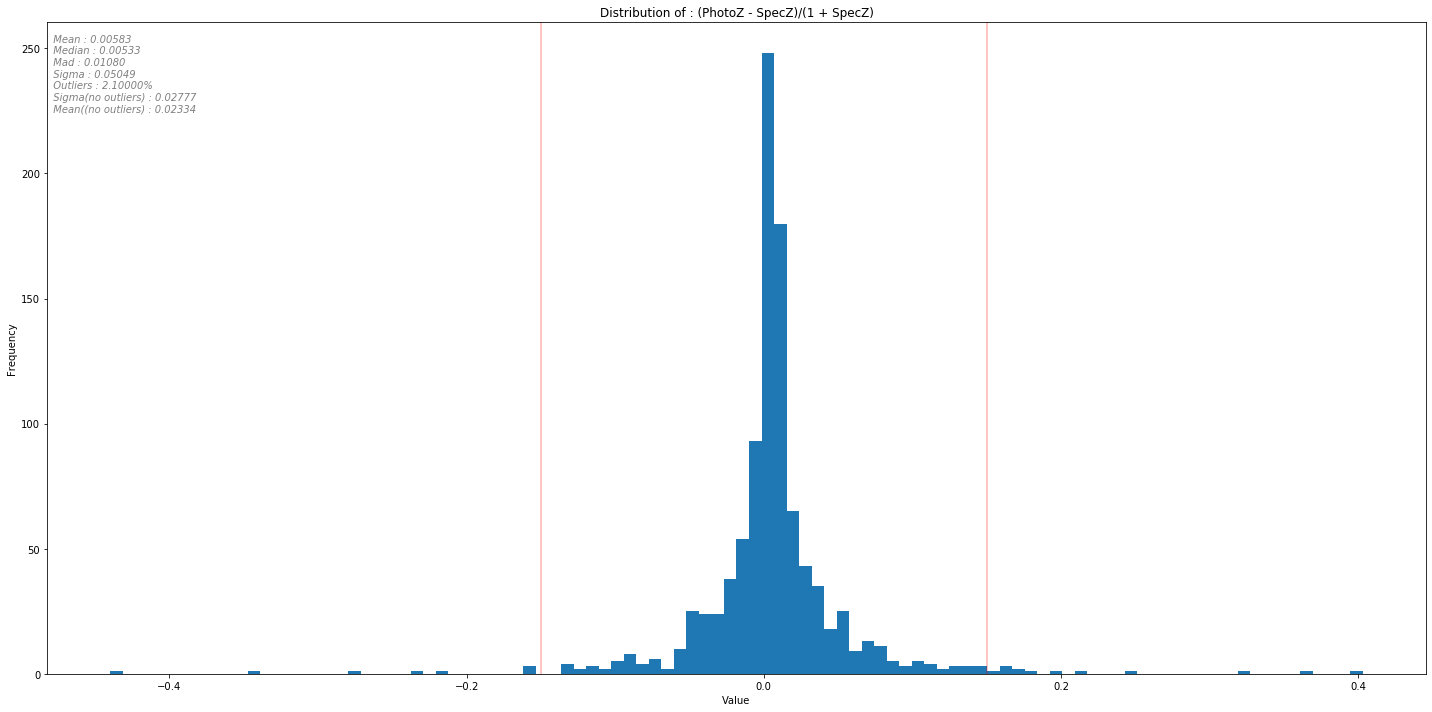

In [15]:
_ = displayHistogram(data, mean, median, mad, sigma, outliersPercent, sigmaNoOutliers, meanNoOutliers)

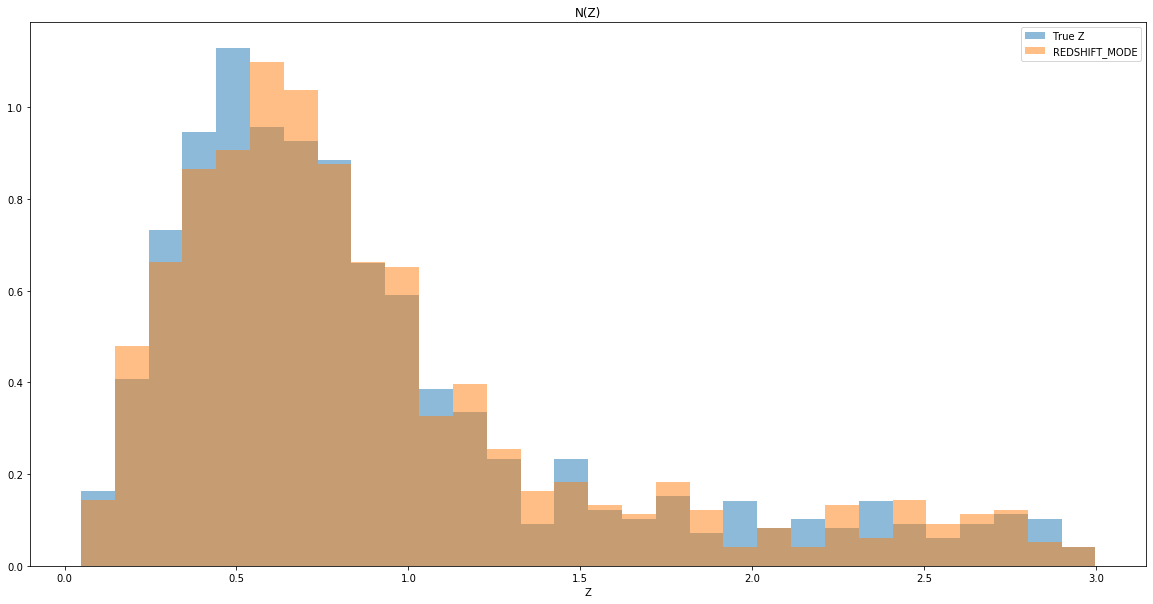

In [16]:
plt.figure()
plt.title('N(Z)')
bins = plt.hist(phz_cut_catalog['z'], bins=30, alpha=0.5, density=True, label='True Z')
plt.hist(phz_cut_catalog[phz_column], bins=bins[1], alpha=0.5, density=True, label=phz_column)
plt.xlabel('Z')
plt.legend()
plt.show()

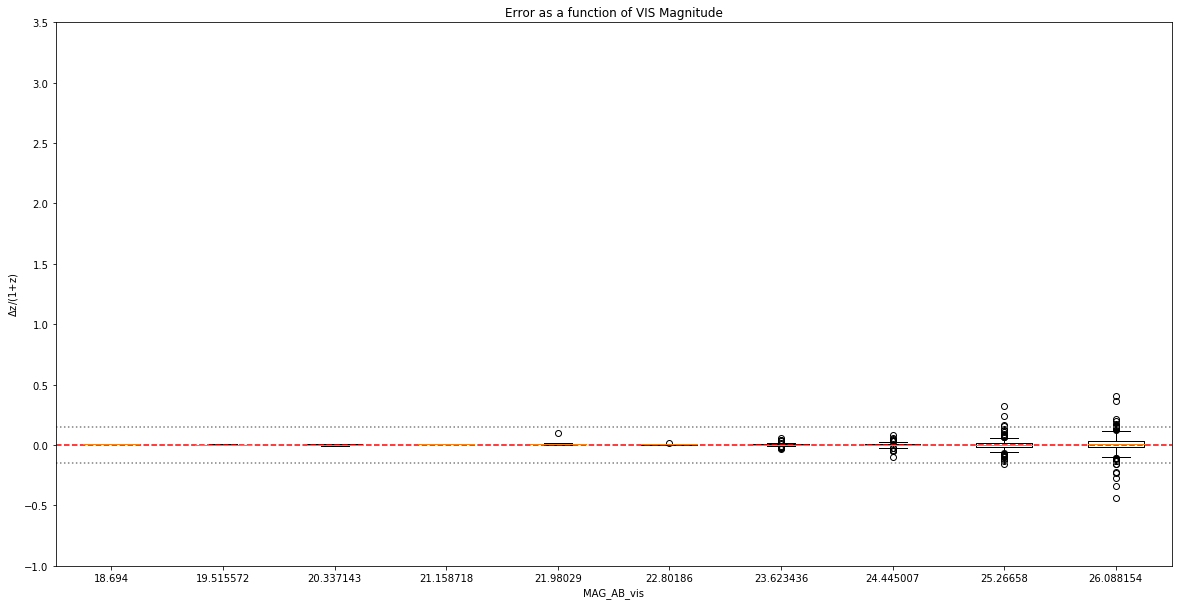

In [17]:
_ = boxPlot(phz_cut_catalog['MAG_AB_vis'], data)
plt.title('Error as a function of VIS Magnitude')
plt.ylim(-1, 3.5)
plt.show()

# PHZ flagged sources

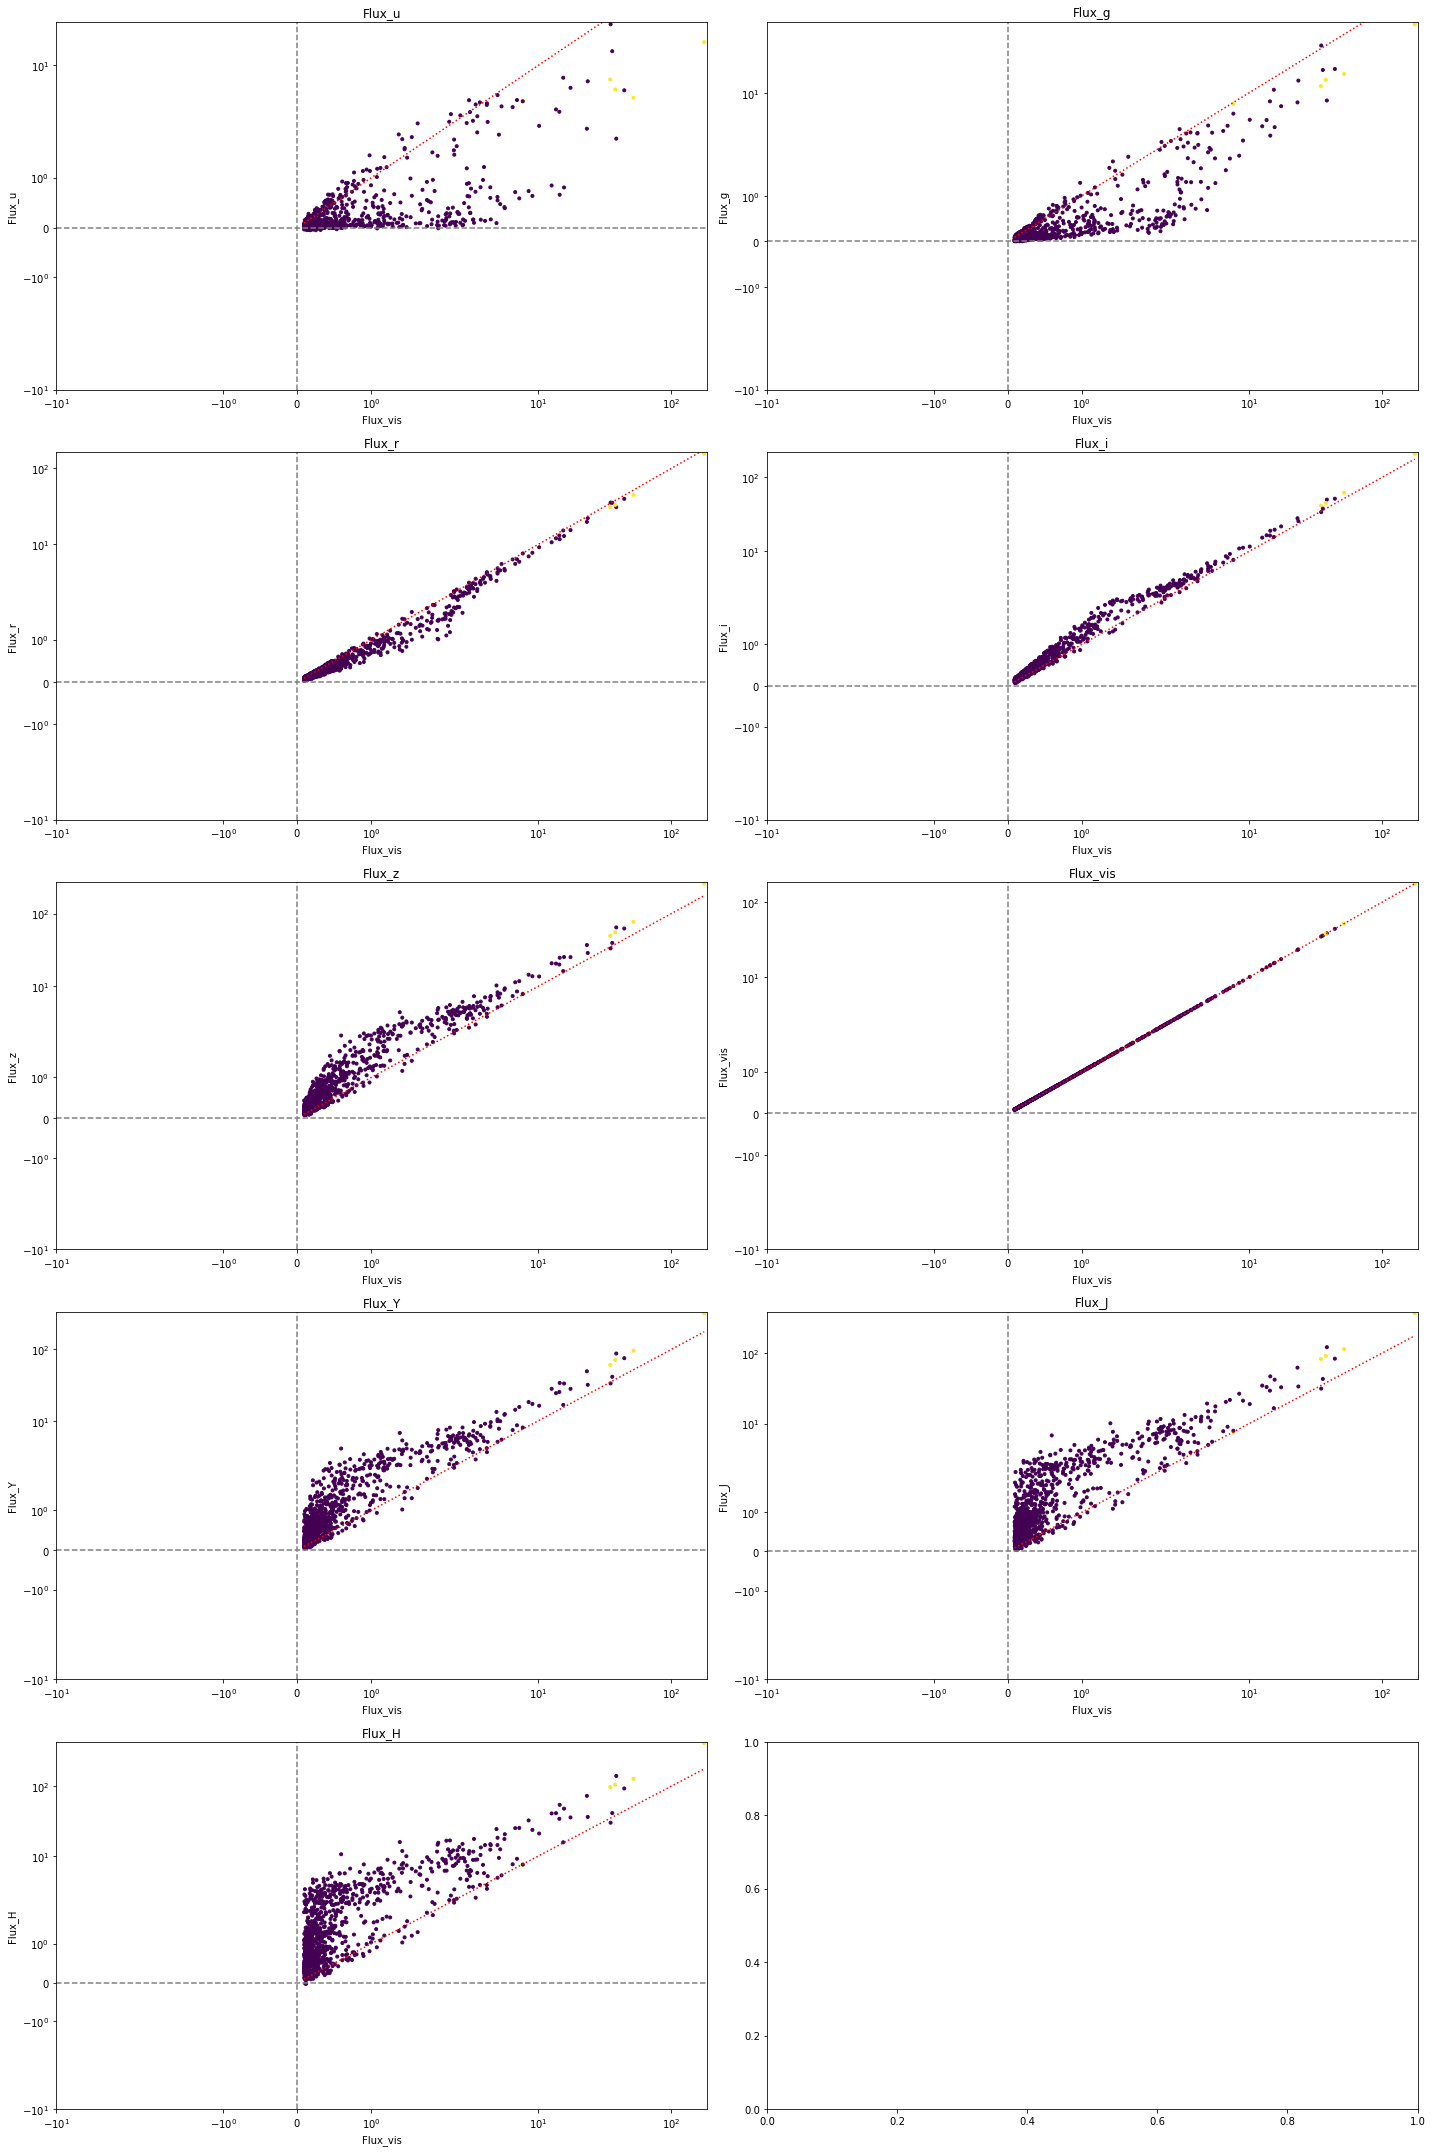

In [18]:
n_filters = len(nnpz_config['target_catalog_filters'])
ncols = 2
nrows = n_filters // ncols + (n_filters % ncols > 0)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 30))
axes = axes.ravel()

vis_min = np.min(phz_catalog['Flux_vis'])
vis_max = np.max(phz_catalog['Flux_vis'])

for i, (flux, error) in enumerate(nnpz_config['target_catalog_filters']):
    axes[i].scatter(phz_catalog['Flux_vis'], phz_catalog[flux], marker='.', c=phz_catalog['FLAGS_1'])
    axes[i].set_title(f'{flux}')
    axes[i].set_xlabel('Flux_vis')
    axes[i].set_ylabel(flux)
    axes[i].set_xlim(-10)
    axes[i].set_ylim(-10)
    axes[i].plot([vis_min, vis_max], [vis_min, vis_max], c='red', linestyle=':')
    axes[i].axvline(0, 0, 1, c='gray', linestyle='--')
    axes[i].axhline(0, 0, 1, c='gray', linestyle='--')
    axes[i].set_xscale('symlog')
    axes[i].set_yscale('symlog')
    
plt.tight_layout()

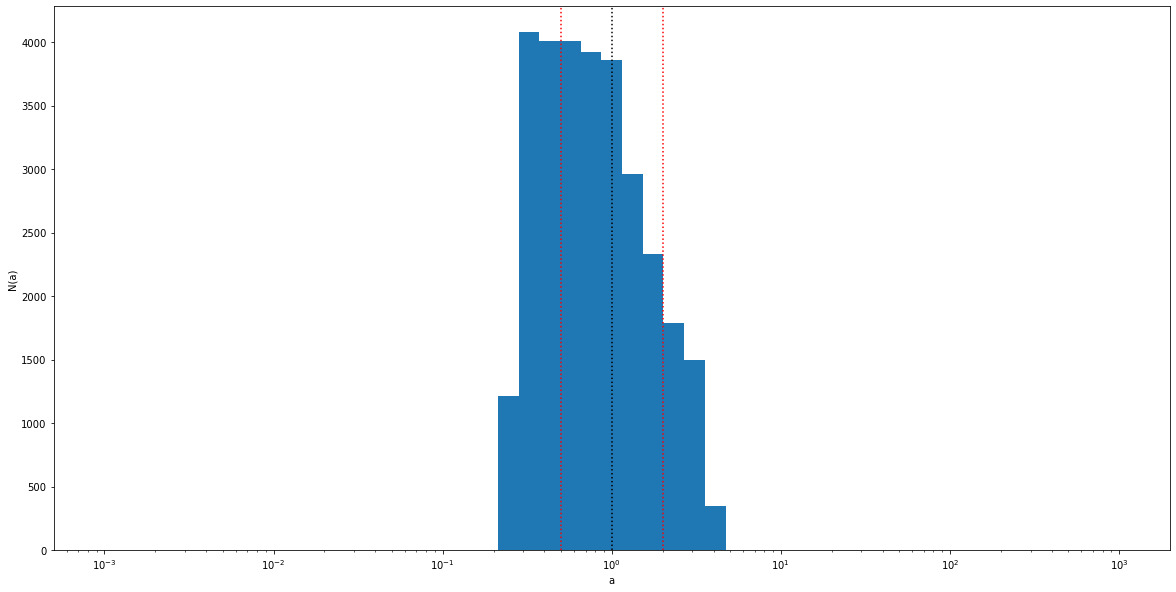

In [19]:
plt.figure()
plt.hist(phz_catalog['NEIGHBOR_SCALING'].ravel(), bins=10**np.linspace(-3., 3.))
plt.xscale('log')
plt.axvline(1, 0, 1, c='black', linestyle=':')
plt.axvline(2, 0, 1, c='red', linestyle=':')
plt.axvline(0.5, 0, 1, c='red', linestyle=':')
plt.xlabel('a')
plt.ylabel('N(a)')
plt.show()

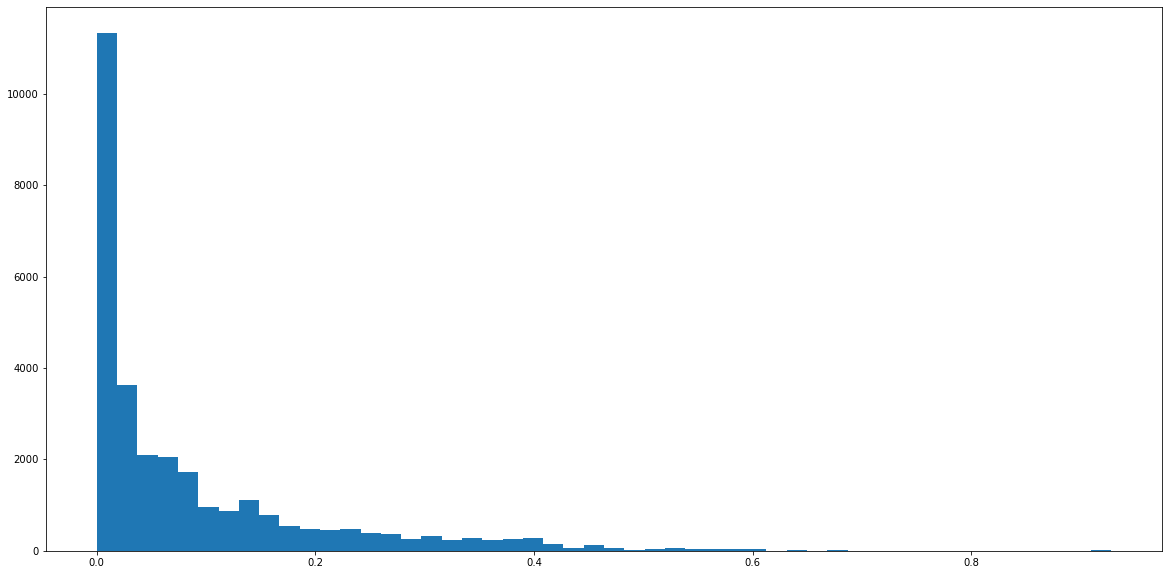

In [20]:
plt.figure()
plt.hist(phz_catalog['NEIGHBOR_WEIGHTS'][phz_catalog['FLAGS_1']==False].ravel(), bins=50)
plt.show()

In [21]:
phz_catalog['FLAGS_1'].sum()

5